In [178]:
import warnings 
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error, mean_absolute_error, max_error
from sklearn.tree import DecisionTreeRegressor

Build a model to predict product's demand 

In [3]:
filename ="historical_product_demand.csv"

In [4]:
path= os.path.join(os.getcwd(), filename)

In [5]:
df = pd.read_csv(path) # Enter the filename 

In [ ]:
#for the sake of simplicty, i will focus on the first 10000 rows 
df_new =df.head(10000)

In [7]:
df_new.head(10)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
5,Product_0979,Whse_J,Category_028,2012/4/19,500
6,Product_0979,Whse_J,Category_028,2012/6/5,500
7,Product_0979,Whse_J,Category_028,2012/6/27,500
8,Product_0979,Whse_J,Category_028,2012/7/23,500
9,Product_0979,Whse_J,Category_028,2012/8/29,500


In [8]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Product_Code      10000 non-null  object
 1   Warehouse         10000 non-null  object
 2   Product_Category  10000 non-null  object
 3   Date              10000 non-null  object
 4   Order_Demand      10000 non-null  object
dtypes: object(5)
memory usage: 390.8+ KB


In [9]:
df_new.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,10000,10000,10000,10000,10000
unique,607,3,22,323,560
top,Product_1359,Whse_J,Category_019,2012/3/8,1000
freq,624,4579,5243,80,996


In [10]:
#check for missing values
df_new.isna().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [11]:
#check for duplicates
df_new.duplicated().sum()

np.int64(205)

In [12]:
df_new["Date"]

0       2012/7/27
1       2012/1/19
2        2012/2/3
3        2012/2/9
4        2012/3/2
          ...    
9995     2012/2/2
9996     2012/2/6
9997     2012/2/7
9998     2012/2/8
9999    2012/2/24
Name: Date, Length: 10000, dtype: object

In [13]:
df_new["Date"] = pd.to_datetime(df["Date"])
df_new["Date"]

0      2012-07-27
1      2012-01-19
2      2012-02-03
3      2012-02-09
4      2012-03-02
          ...    
9995   2012-02-02
9996   2012-02-06
9997   2012-02-07
9998   2012-02-08
9999   2012-02-24
Name: Date, Length: 10000, dtype: datetime64[ns]

In [14]:
#since there are too many products, can i group them into categories?
df_new["Product_Category"].value_counts().sort_values(ascending=False)

Product_Category
Category_019    5243
Category_005     898
Category_001     521
Category_007     468
Category_009     468
Category_006     428
Category_021     340
Category_023     323
Category_024     299
Category_030     227
Category_020     183
Category_028     176
Category_022     129
Category_011     107
Category_026      65
Category_015      46
Category_033      29
Category_003      24
Category_032      18
Category_004       4
Category_018       3
Category_013       1
Name: count, dtype: int64

In [15]:
#list all the products in each category
df_new.groupby("Product_Category")["Product_Code"].unique()

Product_Category
Category_001    [Product_1938, Product_0613, Product_1763, Pro...
Category_003    [Product_1719, Product_1723, Product_1722, Pro...
Category_004                                       [Product_1102]
Category_005    [Product_1970, Product_1581, Product_2015, Pro...
Category_006    [Product_1159, Product_1157, Product_1150, Pro...
Category_007    [Product_0187, Product_1023, Product_0223, Pro...
Category_009    [Product_2128, Product_2118, Product_2133, Pro...
Category_011    [Product_0664, Product_2039, Product_0315, Pro...
Category_013                                       [Product_0548]
Category_015    [Product_0102, Product_0444, Product_0453, Pro...
Category_018                         [Product_0432, Product_1822]
Category_019    [Product_1234, Product_1451, Product_1274, Pro...
Category_020    [Product_1064, Product_1065, Product_1068, Pro...
Category_021    [Product_0344, Product_0345, Product_0288, Pro...
Category_022    [Product_0535, Product_0533, Product_0542, 

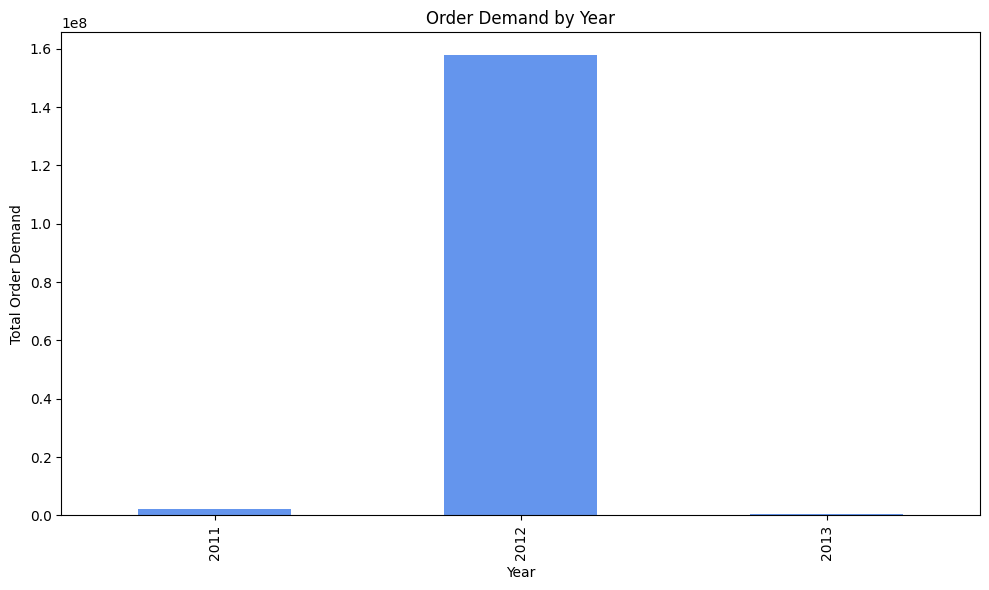

In [16]:
#plot orderdemand by year
# Ensure Order_Demand is numeric (convert if necessary)
df_new["Order_Demand"] = pd.to_numeric(df_new["Order_Demand"], errors='coerce')  # coerce will turn invalid values to NaN

# Drop rows with NaN values in Order_Demand
df_new = df_new.dropna(subset=["Order_Demand"])

# Grouping by year and summing Order_Demand for each year
df_new.groupby(df_new["Date"].dt.year)["Order_Demand"].sum().plot(
    kind='bar', 
    color='cornflowerblue', 
    figsize=(10, 6)
)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Total Order Demand')
plt.title('Order Demand by Year')

# Show the plot
plt.tight_layout()
plt.show()

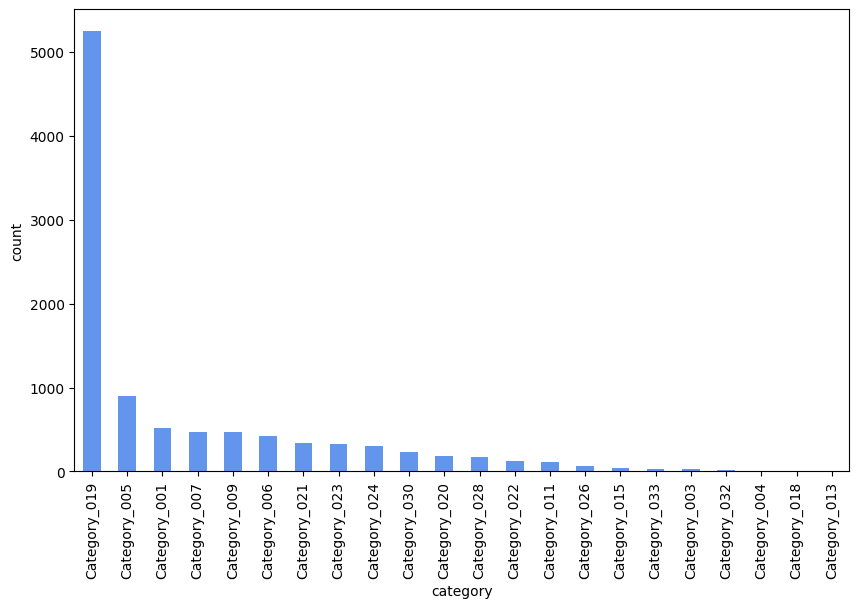

In [17]:
# Plot product categories
df_new.Product_Category.value_counts().plot(kind = 'bar', color = 'cornflowerblue', figsize = (10, 6))
plt.xlabel('category')
plt.ylabel('count')
plt.show()


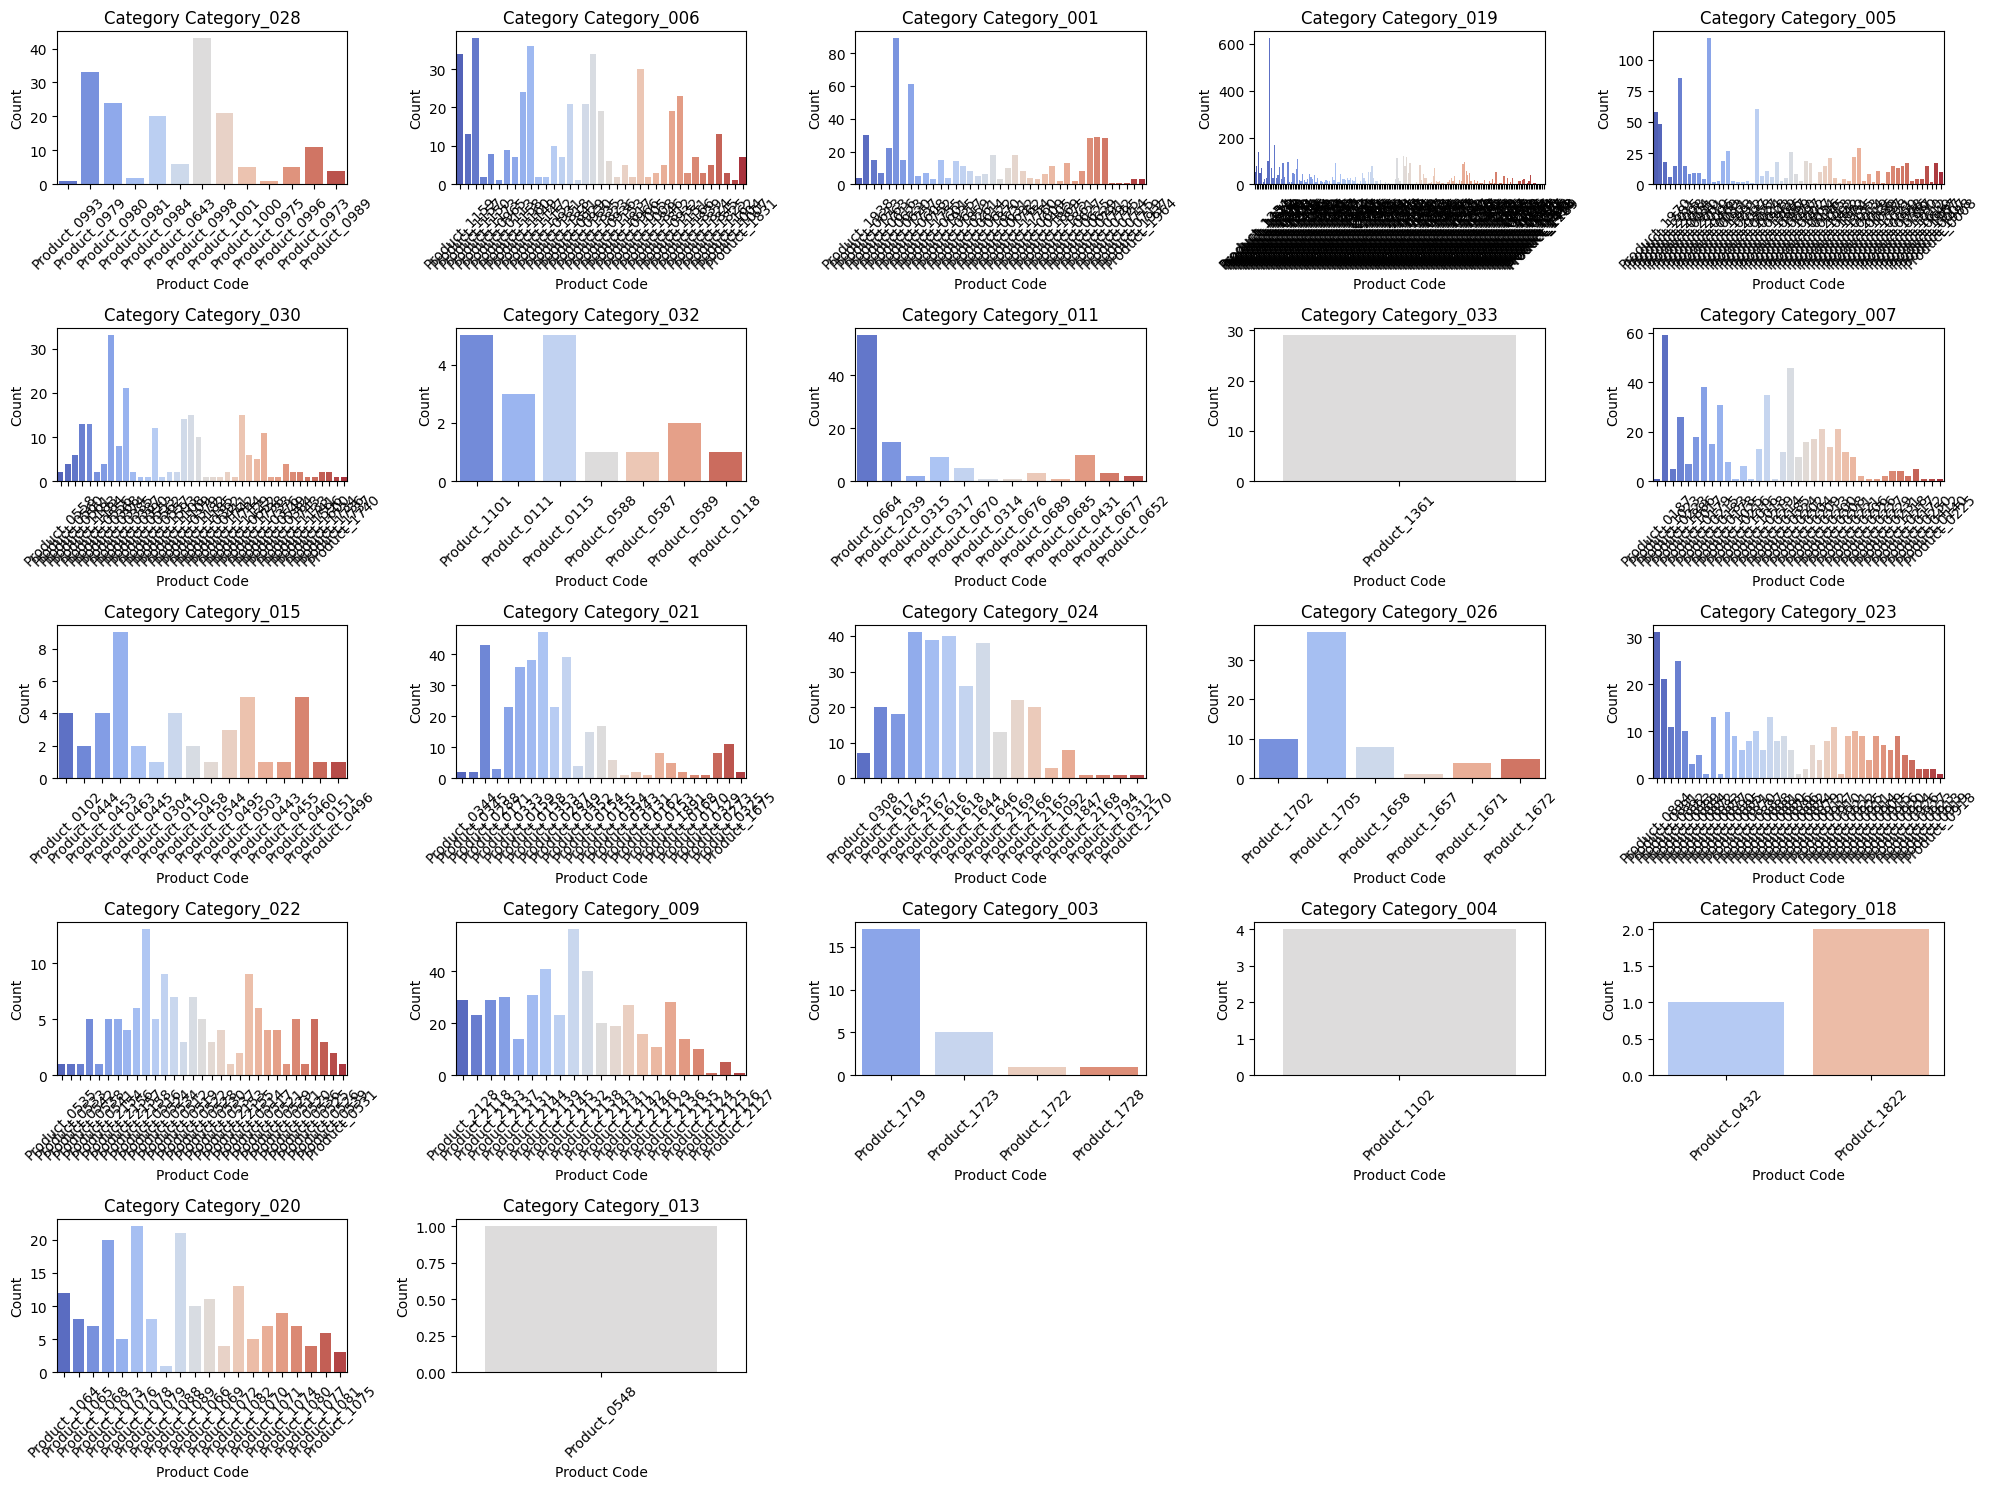

In [18]:
# Get unique product categories
categories = df_new['Product_Category'].unique()

# Create subplots: 5 plots per row, adjust the number of rows accordingly
n_cols = 5
n_rows = len(categories) // n_cols + (len(categories) % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten axes array to make it easier to iterate
axes = axes.flatten()

# Loop through categories and plot each in a separate subplot
for i, category in enumerate(categories):
    ax = axes[i]
    category_data = df_new[df_new['Product_Category'] == category]
    
    sns.countplot(x="Product_Code", data=category_data, ax=ax, palette="coolwarm")
    ax.set_title(f"Category {category}")
    ax.set_xlabel("Product Code")
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel("Count")

    # Rotate x labels if needed for better visibility
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Remove empty subplots if the number of categories isn't a perfect grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to make room for labels
plt.tight_layout()
plt.show()

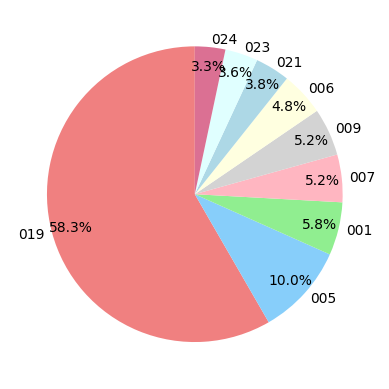

<Figure size 1200x900 with 0 Axes>

In [19]:
#pie chart for the following product categories
categories = ['019', '005', '001', '007', '009', '006', '021', '023', '024']
values = [5243, 898, 521, 468, 468, 428, 340, 323, 299]
colors = ['lightcoral', 'lightskyblue', 'lightgreen', 'lightpink', 'lightgray', 'lightyellow', 'lightblue', 'lightcyan', 'palevioletred']
plt.pie(values, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.87, labeldistance=1.05)
plt.figure(figsize=(12,9))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of Product Categories by Warehouse')

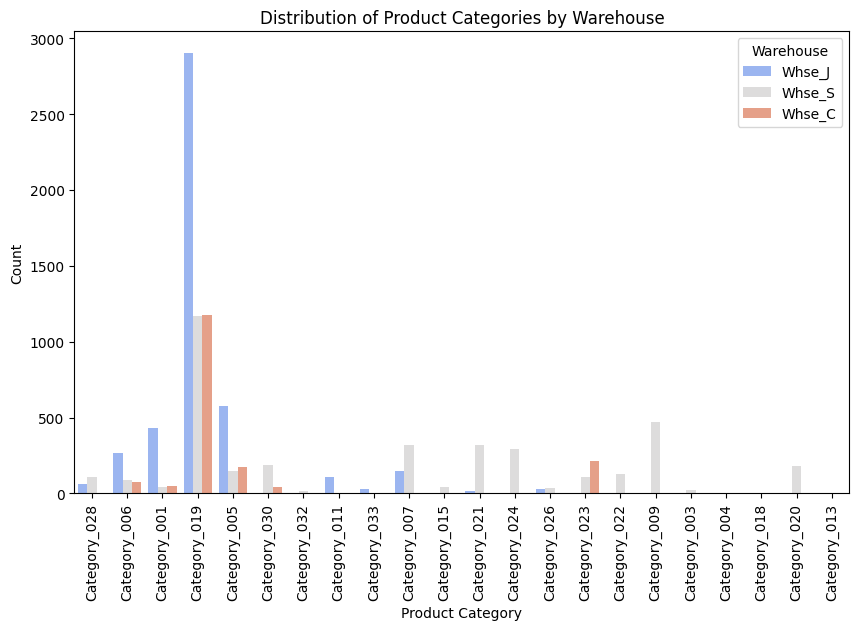

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x="Product_Category", hue="Warehouse", data=df_new, palette="coolwarm")
plt.xlabel("Product Category")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Distribution of Product Categories by Warehouse")

In [37]:
#dropped date column
df_drop = df_new.drop(['Date'], axis =1)

In [ ]:
#bin the order demand column
#0-499 = low demand
#500-999 = medium demand
#1000+ = high demand

bins = [0, 500, 1000, float('inf')]
labels =['Low_Demand','Medium_Demand', 'High_Demand']

df_drop['Order_Demand'] = pd.cut(df_drop['Order_Demand'], bins=bins, labels=labels, right=False)

df_drop['Order_Demand'].value_counts()

Order_Demand
High_Demand      6252
Low_Demand       3295
Medium_Demand     453
Name: count, dtype: int64

In [34]:
df_drop.head(100)

,Product_Code,Warehouse,Product_Category,Order_Demand
0,Product_0993,Whse_J,Category_028,Low_Demand
1,Product_0979,Whse_J,Category_028,Medium_Demand
2,Product_0979,Whse_J,Category_028,Medium_Demand
3,Product_0979,Whse_J,Category_028,Medium_Demand
4,Product_0979,Whse_J,Category_028,Medium_Demand
...,...,...,...,...
95,Product_1512,Whse_J,Category_019,High_Demand
96,Product_1512,Whse_J,Category_019,High_Demand
97,Product_1512,Whse_J,Category_019,High_Demand
98,Product_1274,Whse_J,Category_019,High_Demand


In [45]:
OrdinalEncoder = OrdinalEncoder()

df_drop['Order_Demand'] = OrdinalEncoder.fit_transform(df_drop[['Order_Demand']]) #df_drop[['Order_Demand']] (double brackets) ensures it's a 2D DataFrame.

In [ ]:
df_drop["Order_Demand"] #new encoded column

0       1.0
1       2.0
2       2.0
3       2.0
4       2.0
       ... 
9995    0.0
9996    0.0
9997    0.0
9998    0.0
9999    0.0
Name: Order_Demand, Length: 10000, dtype: float64

In [ ]:
#drop the encoded order_demand column
df_drop_drop =df_drop.drop(['Order_Demand'], axis=1)

In [ ]:
#Onehot encoding
OneHotEncoder = OneHotEncoder()

In [60]:
OneHotEncoder = pd.get_dummies(df_drop_drop, dtype = int)
df_onehot =pd.get_dummies(df_drop_drop, dtype =int)

In [61]:
#append the encoded order demand column to df_onehot
df_combined  = pd.concat([df_onehot, df_drop['Order_Demand']], axis=1)

In [63]:
#new dataframe to be split into training and testing
df_combined

,Product_Code_Product_0002,Product_Code_Product_0007,Product_Code_Product_0008,Product_Code_Product_0011,Product_Code_Product_0012,Product_Code_Product_0013,Product_Code_Product_0014,Product_Code_Product_0018,Product_Code_Product_0020,Product_Code_Product_0021,...,Product_Category_Category_021,Product_Category_Category_022,Product_Category_Category_023,Product_Category_Category_024,Product_Category_Category_026,Product_Category_Category_028,Product_Category_Category_030,Product_Category_Category_032,Product_Category_Category_033,Order_Demand
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [ ]:
#split into training and testing sets  
X=df_combined.iloc[:, :-1]
y=df_combined.iloc[:, -1]

In [85]:
#split into training, validation and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, random_state = 42) #random_state = 42 ensures you get same split every time
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

In [ ]:
modelTree = DecisionTreeRegressor().fit(X_train, y_train)
y_pred = modelTree.predict(X_test)


In [125]:
print("scoreDT:", modelTree.score(X_test, y_test))
print("mean_absolute_error:", mean_absolute_error(y_test, y_pred))
print("mean_squared_error:", mean_squared_error(y_test, y_pred))
print("r2_score:", r2_score(y_test, y_pred))
print("max_error:", max_error(y_test, y_pred))


scoreDT: 0.7249225238021972
mean_absolute_error: 0.10436047837284497
mean_squared_error: 0.09093813793370784
r2_score: 0.7249225238021972
max_error: 2.0


In [160]:
#define hyperparameters
param_grid = {
    
    'criterion': ['squared_error', 'friedman_mse'],  # Splitting criteria
    'max_depth': [None, 5, 10, 20, 30, 40],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Min samples needed to split a node
    'min_samples_leaf': [1, 2, 4, 10],  # Min samples per leaf node
    'max_features': [None, 'sqrt', 'log2']  # Features considered for best split
}

In [164]:
#Gridsearch
model_optimized = DecisionTreeRegressor(random_state=42)
#perform a  grid search
grid_search = GridSearchCV(model_optimized, param_grid=param_grid, cv=5, 
                           n_jobs=-1, scoring="r2")
grid_search.fit(X_train, y_train)

#Gridsearch results
best_grid_model = grid_search.best_estimator_
print("Best Hyperparameters (Grid Search):", grid_search.best_params_)

Best Hyperparameters (Grid Search): {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [169]:
# Perform Randomized Search (faster)
random_search = RandomizedSearchCV(model_optimized, param_distributions=param_grid,
                                   n_iter=20, cv=5, n_jobs=-1, scoring='r2', random_state=42)

random_search.fit(X_train, y_train)

# Best parameters & model
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_


In [176]:

#Validation set using grid search
y_pred_val =best_grid_model.predict(X_val)
print("scoreDT_grid:", modelTree.score(X_val, y_val))
print("mean_absolute_error_grid:", mean_absolute_error(y_val, y_pred_val))
print("mean_squared_error_grid:", mean_squared_error(y_val, y_pred_val))
print("r2_score_grid:", r2_score(y_val, y_pred_val))
print("max_error_grid:", max_error(y_val, y_pred_val))

scoreDT_grid: 0.8513977189254172
mean_absolute_error_grid: 0.11774859361373774
mean_squared_error_grid: 0.10494470736163862
r2_score_grid: 0.6896953942452857
max_error_grid: 2.0


In [177]:
#validation data using random search
y_pred_val_random =best_model_random.predict(X_val)
print("scoreDT_random:", modelTree.score(X_val, y_val))
print("mean_absolute_error_random:", mean_absolute_error(y_val, y_pred_val_random))
print("mean_squared_error_random:", mean_squared_error(y_val, y_pred_val_random))
print("r2_score_random:", r2_score(y_val, y_pred_val_random))
print("max_error_random:", max_error(y_val, y_pred_val_random))

scoreDT_random: 0.8513977189254172
mean_absolute_error_random: 0.11512153749248978
mean_squared_error_random: 0.10784019395298713
r2_score_random: 0.6811339065077451
max_error_random: 2.0


In [180]:
#Use the SVR model
modelSVR = SVR(kernel='rbf', C=1.0, epsilon=0.1)
modelSVR.fit(X_train, y_train)
y_pred_SVR = modelSVR.predict(X_test)
print("scoreSVR:", modelSVR.score(X_test, y_test))
print("mean_absolute_error_SVR:", mean_absolute_error(y_test, y_pred_SVR))
print("mean_squared_error_SVR:", mean_squared_error(y_test, y_pred_SVR))
print("r2_score_SVR:", r2_score(y_test, y_pred_SVR))
print("max_error_SVR:", max_error(y_test, y_pred_SVR))

scoreSVR: 0.7108696481992922
mean_absolute_error_SVR: 0.16393668676047318
mean_squared_error_SVR: 0.09558389213214784
r2_score_SVR: 0.7108696481992922
max_error_SVR: 1.9002061762059679
